<a href="https://colab.research.google.com/github/manoharkaranth/Time_Series_Analysis/blob/master/Power_Consumption_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Problem statement:** Forecast weekly power consumption for Household electricity dataset.

<br/><br/>

In [ ]:
# Importing libraries.
import numpy as np
import pandas as pd
from numpy import nan

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

##### Downloading dataset from kaggle.com

In [ ]:
# Installing dependency. Just a formality as Colab is celebrated for catering ready to go setup. 
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json

token = 'COPY YOUR KAGGLE API HERE'

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s 'Household Electric Power Consumption'

ref                                                              title                                             size  lastUpdated          downloadCount  
---------------------------------------------------------------  ------------------------------------------------  ----  -------------------  -------------  
uciml/electric-power-consumption-data-set                        Household Electric Power Consumption              19MB  2016-08-23 17:02:15           9329  
navinmundhra/daily-power-generation-in-india-20172020            Daily Power Generation in India (2017-2020)        3MB  2020-08-27 11:48:02           1989  
steventaylor11/stated-preferences-for-car-choice                 Stated Preferences for Car Choice                  7KB  2019-05-03 07:36:20            395  
nitinsss/goa-india-weather-data                                  Historical Weather data of Goa, India              2MB  2019-09-21 06:03:00            174  
new-york-state/nys-residential-homes-energy-efficien

###### Downloading from kaggle.com

In [ ]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set/content

 62% 12.0M/19.4M [00:00<00:00, 19.7MB/s]
100% 19.4M/19.4M [00:00<00:00, 39.5MB/s]


In [ ]:
# Unzipping the downloaded file.
!unzip {/content}/datasets/uciml/electric-power-consumption-data-set/electric-power-consumption-data-set.zip

Archive:  {/content}/datasets/uciml/electric-power-consumption-data-set/electric-power-consumption-data-set.zip
  inflating: household_power_consumption.txt  


In [ ]:
# Loading the downloaded file into dataframe.
df = pd.read_csv('{/content}/datasets/uciml/electric-power-consumption-data-set/electric-power-consumption-data-set.zip', sep = ';',parse_dates = True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# A quick look at the dataframe.
df.head(3)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [ ]:
df.shape

(2075259, 9)

In [ ]:
df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [ ]:
# Concatenating date and time columns to 'date_time' columns.

df['date_time'] = df['Date'].str.cat(df['Time'], sep= ' ')
df.drop(['Date', 'Time'], inplace= True, axis = 1)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,16/12/2006 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,16/12/2006 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,16/12/2006 17:28:00


In [ ]:
df.set_index(['date_time'], inplace=True)
df.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [ ]:
# Replacing each '?'characters with NaN value.
df.replace('?', nan, inplace=True)

In [ ]:
# This will allow us to work with the data as one array of floating point values rather than mixed types (less efficient.)
df = df.astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 206.7+ MB


In [ ]:
np.isnan(df).sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

##### Filling the missing values.

In [ ]:
def fill_missing(df):
    one_day = 24*60
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(df[row, col]):
                df[row, col] = df[row-one_day, col]

In [ ]:
fill_missing(df.values)

In [ ]:
np.isnan(df).sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
df.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
16/12/2006 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
16/12/2006 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0


##### Saving the cleaned file and converting it to CSV.

In [ ]:
df.to_csv("Cleaned.csv")

In [ ]:
df = pd.read_csv('Cleaned.csv', parse_dates = True, index_col = 'date_time')

In [ ]:
df.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0


##### Downsampling the data into dáy-wise bins and sum the values of the timestamps falling into a bin.

In [ ]:
data = df.resample('D').sum()

In [ ]:
data.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0


##### Plotting all features in various time stamps.

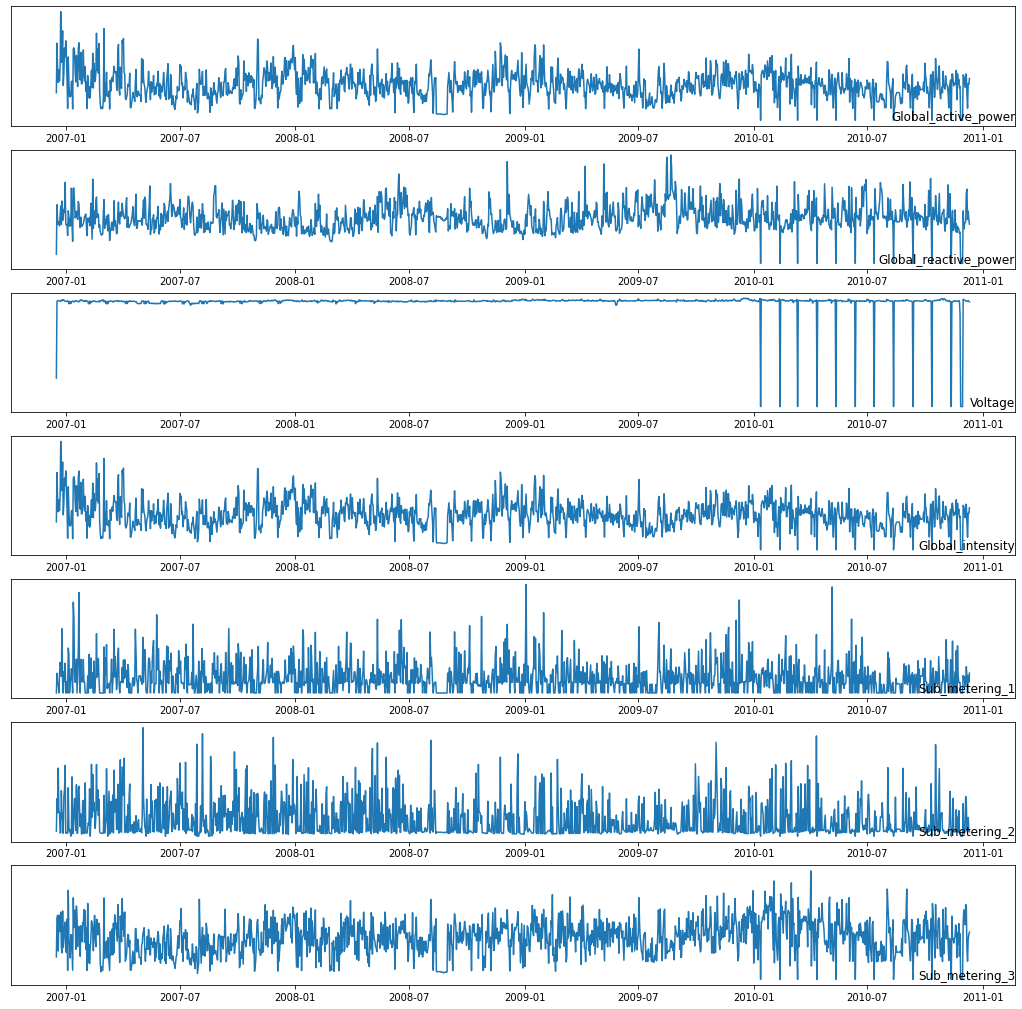

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    plt.plot(data[name])
    plt.title(name, y=0, loc = 'right')
    plt.yticks([])
plt.show()
fig.tight_layout()

##### Exploring Active power consumption for each year.

In [ ]:

years = ['2007', '2008', '2009', '2010']

##### Year wise plotting of feature Global_active_power.

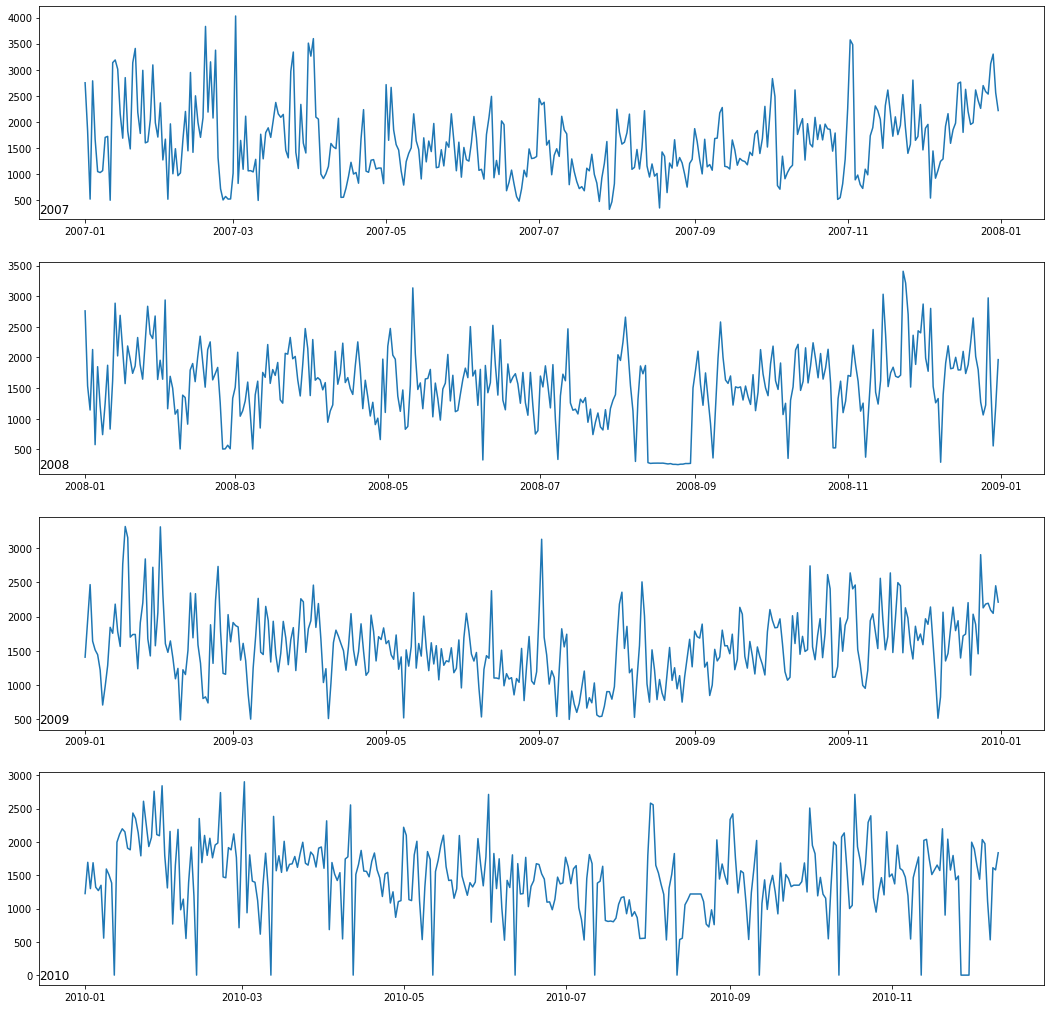

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    plt.plot(active_power_data['Global_active_power'])
    plt.title(str(year), y = 0, loc = 'left')
plt.show()
fig.tight_layout()

In [ ]:
data['2006'].head(6)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0
2006-12-21,1723.288,144.434,347096.41,7266.4,1765.0,2692.0,10456.0


##### Year wise histogram plot of feature Global_active_power.

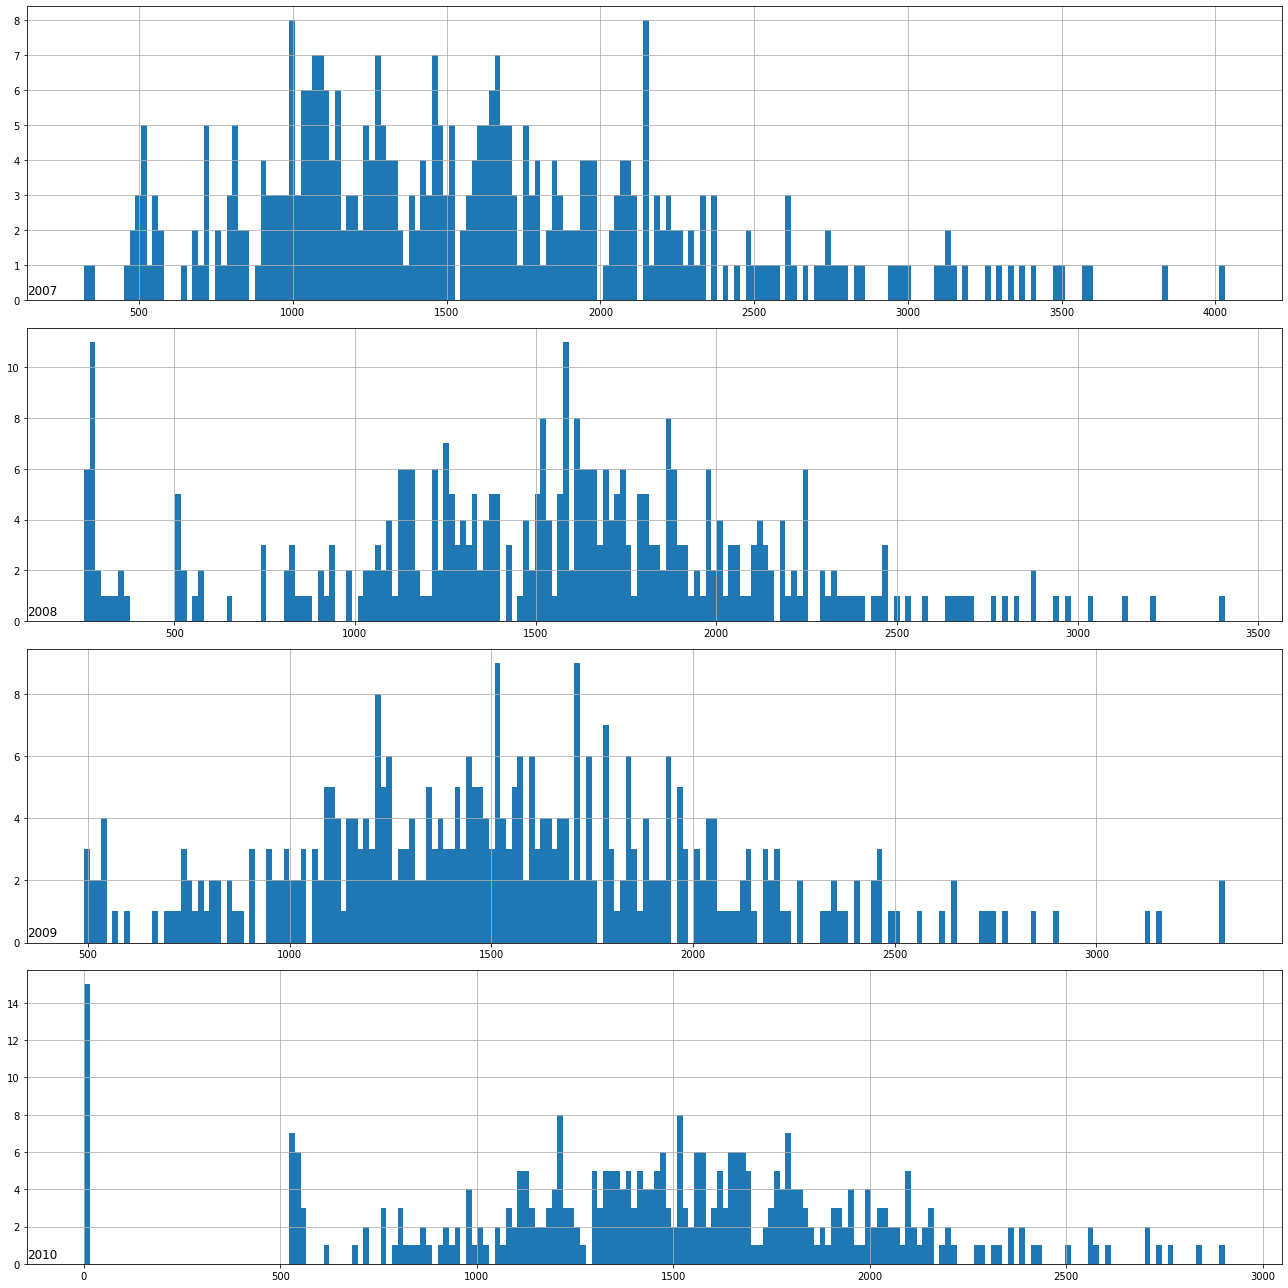

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    active_power_data['Global_active_power'].hist(bins = 200)
    plt.title(str(year), y = 0, loc = 'left')

fig.tight_layout()

##### Histogram plot for All Features.

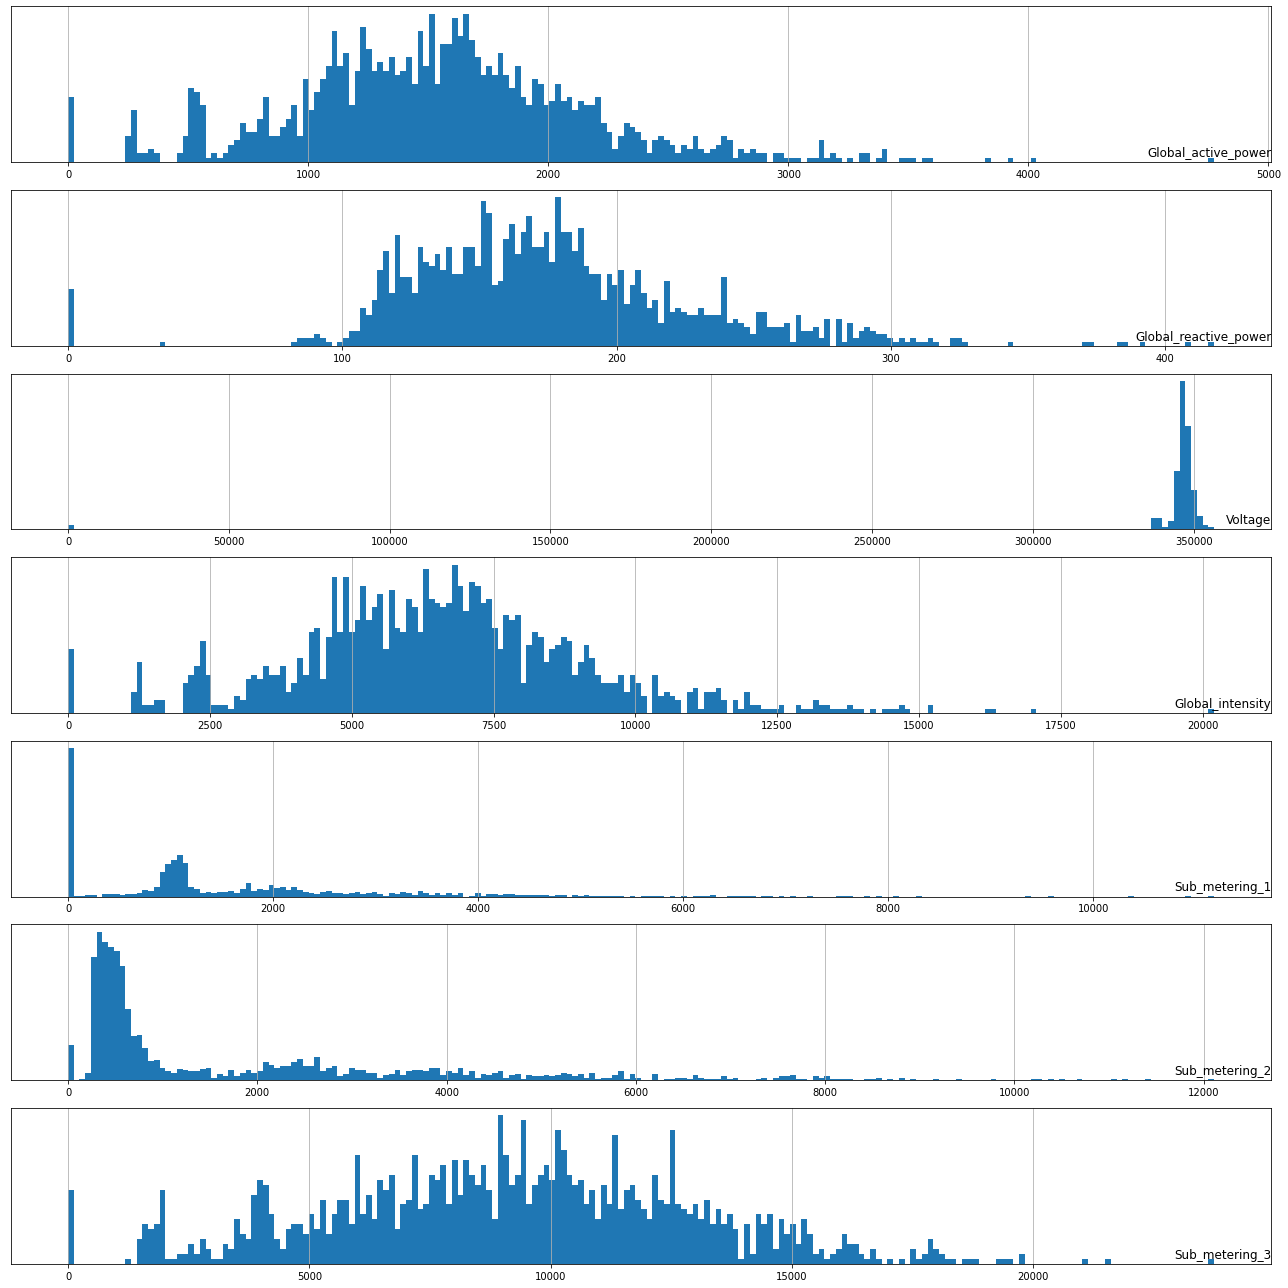

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    data[name].hist(bins=200)
    plt.title(name, y=0, loc = 'right')
    plt.yticks([])
fig.tight_layout()

##### Ploting power consumption hist for each month of 2007.

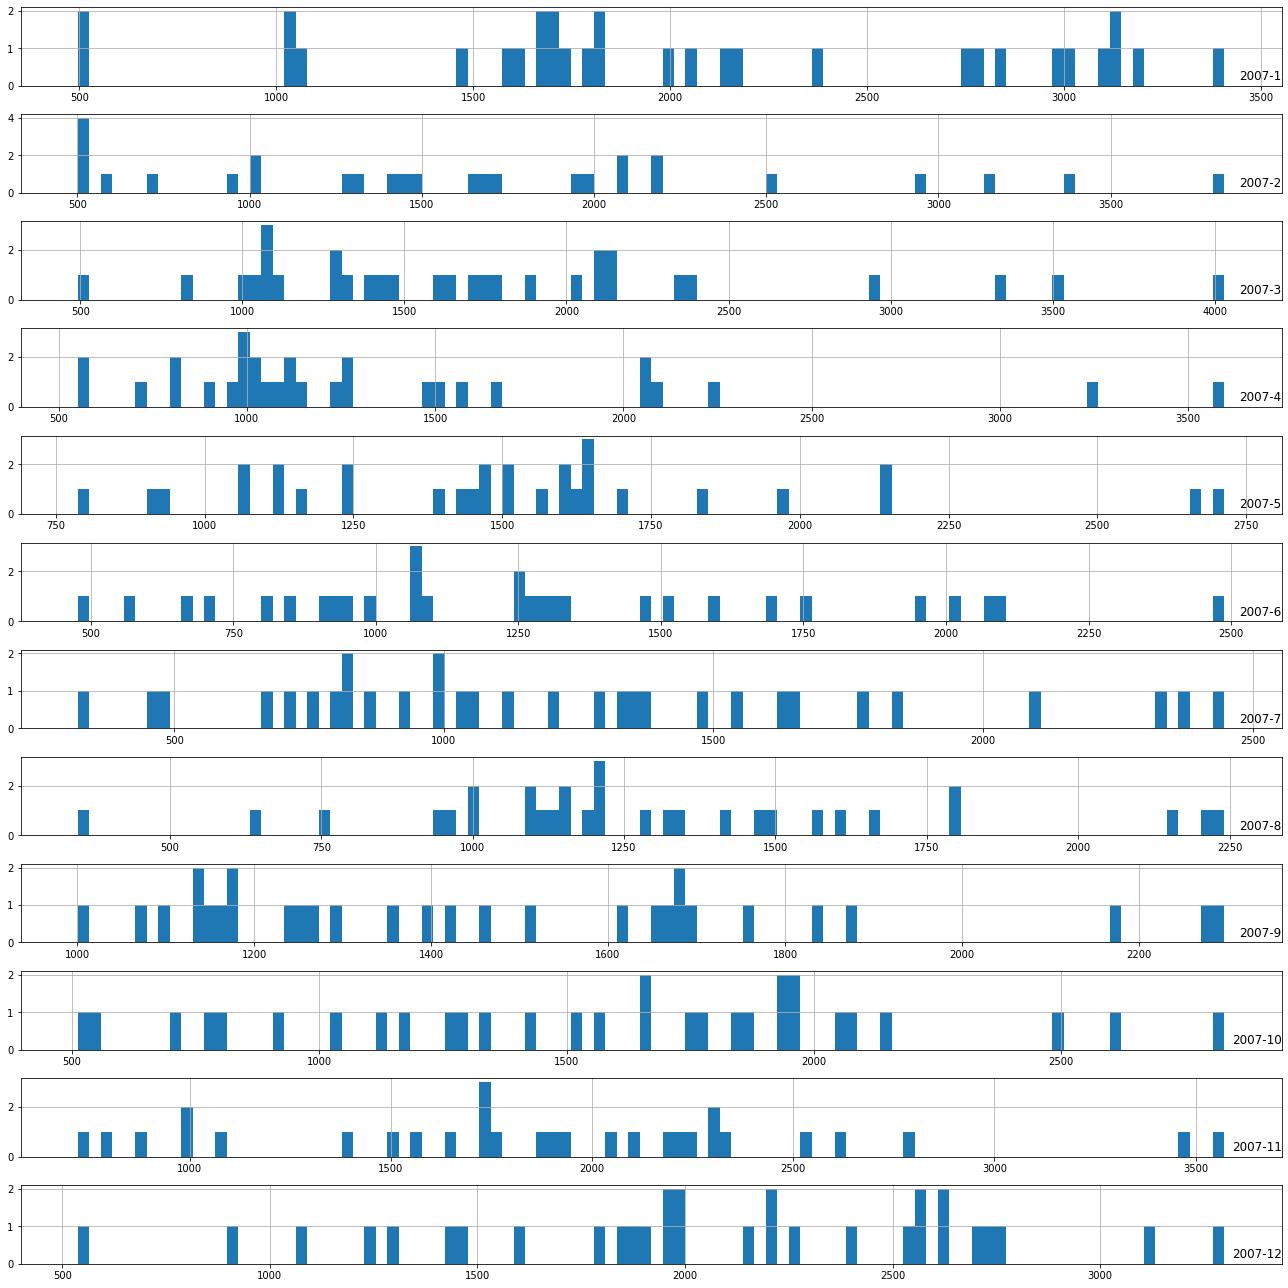

In [ ]:
months = [i for i in range(1,13)]

fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(months)):
    ax = plt.subplot(len(months), 1, i+1)
    month = '2007-' + str(months[i])
    active_power_data = data[month]
    active_power_data['Global_active_power'].hist(bins = 100)
    #ax.set_xlim(0,5)
    plt.title(month, y = 0, loc = 'right')
fig.tight_layout()

In [ ]:
active_power_data['Global_active_power'].head(3)

date_time
2007-12-01    1461.296
2007-12-02    1877.610
2007-12-03    1950.668
Freq: D, Name: Global_active_power, dtype: float64

In [ ]:
data.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0


In [ ]:
data.tail(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2010-12-09,1612.092,201.358,347932.40,6848.2,1805.0,2080.0,8891.0
2010-12-10,1579.692,170.268,345975.37,6741.2,1104.0,780.0,9812.0
2010-12-11,1836.822,151.144,343926.57,7826.2,2054.0,489.0,10308.0


##### Preparing training data.

In [ ]:
# Dataset upto end of 2009 is in train dataset.
data_train = data.loc[:'2009-12-31', :]['Global_active_power']
data_train.head(3)

date_time
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
Freq: D, Name: Global_active_power, dtype: float64

In [ ]:
data_test = data['2010']['Global_active_power']
data_test.head(3)

date_time
2010-01-01    1224.252
2010-01-02    1693.778
2010-01-03    1298.728
2010-01-04    1687.440
2010-01-05    1320.158
Freq: D, Name: Global_active_power, dtype: float64

In [ ]:
data_test.shape

(345,)

In [ ]:
data_train.shape

(1112,)

In [ ]:
data_train = np.array(data_train)

In [ ]:
# Splitting the data week-wise.
X_train, y_train = [], []

for i in range(7, len(data_train)-7):
    X_train.append(data_train[i-7:i])
    y_train.append(data_train[i:i+7])

In [ ]:
# Converting list to numpy array.
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape, y_train.shape

((1098, 7), (1098, 7))

In [ ]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6
0,4773.386,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392
1,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108
2,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196
3,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004
4,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004,1824.760


##### Normalising the dataset between 0 and 1.

In [ ]:
x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)

In [ ]:
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)

In [ ]:
pd.DataFrame(X_train).head(3)

,0,1,2,3,4,5,6
0,0.211996,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304
1,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000
2,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439


In [ ]:
# Converting into 3 dimensions.
X_train = X_train.reshape(1098, 7, 1)

In [ ]:
X_train.shape

(1098, 7, 1)

##### Building LSTM Model.

In [ ]:
reg = Sequential()
reg.add(LSTM(units = 200, activation = 'relu', input_shape=(7,1)))
reg.add(Dense(7))

In [ ]:
reg.compile(loss='mse', optimizer='adam')

In [ ]:
# Training the model.

reg.fit(X_train, y_train, epochs = 100)

Epoch 1/100
35/35 [==============================] - 1s 21ms/step - loss: 0.0587
Epoch 2/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0243
Epoch 3/100
35/35 [==============================] - 1s 18ms/step - loss: 0.0240
Epoch 4/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0241
Epoch 5/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0240
Epoch 6/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0242
Epoch 7/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0240
Epoch 8/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0239
Epoch 9/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0238
Epoch 10/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0242
Epoch 11/100
35/35 [==============================] - 1s 19ms/step - loss: 0.0239
Epoch 12/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0237
Epoch 13/100
35/35 [=====

##### Preparing test dataset and testing the model.

In [ ]:
data_test = np.array(data_test)

In [ ]:
# Splitting the data week wise.
X_test, y_test = [], []

for i in range(7, len(data_test)-7):
    X_test.append(data_test[i-7:i])
    y_test.append(data_test[i:i+7])

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

In [ ]:
# Converting to 3 dimension
X_test = X_test.reshape(331,7,1)
X_test.shape

(331, 7, 1)

In [ ]:
y_pred = reg.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)

In [ ]:
y_pred

array([[1505.4308 , 1543.6656 , 1508.703  , ..., 1587.0901 , 1520.5992 ,
        1508.8319 ],
       [1135.2595 , 1338.4801 , 1367.985  , ..., 1525.5948 , 1468.216  ,
        1447.3218 ],
       [1529.7386 , 1563.0833 , 1525.5912 , ..., 1537.4653 , 1455.1403 ,
        1447.9609 ],
       ...,
       [1083.5922 , 1087.0657 , 1081.2664 , ..., 1007.469  ,  878.3091 ,
         892.96246],
       [1577.7675 , 1446.3958 , 1324.6609 , ..., 1130.9307 ,  986.5485 ,
        1049.0042 ],
       [1631.8475 , 1474.0494 , 1347.4987 , ..., 1192.597  , 1102.8707 ,
        1180.9552 ]], dtype=float32)

In [ ]:
y_true = y_scaler.inverse_transform(y_test)

In [ ]:
y_true

array([[ 555.664, 1593.318, 1504.82 , ...,    0.   , 1995.796, 2116.224],
       [1593.318, 1504.82 , 1383.18 , ..., 1995.796, 2116.224, 2196.76 ],
       [1504.82 , 1383.18 ,    0.   , ..., 2116.224, 2196.76 , 2150.112],
       ...,
       [1892.998, 1645.424, 1439.426, ..., 1973.382, 1109.574,  529.698],
       [1645.424, 1439.426, 2035.418, ..., 1109.574,  529.698, 1612.092],
       [1439.426, 2035.418, 1973.382, ...,  529.698, 1612.092, 1579.692]])

#### Model Evaluation.

In [ ]:
def evaluate_model(y_true, y_predicted):
    scores = []
    
    # Calculating scores for each day.
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    
    # Calculating score for whole prediction.
    total_score = 0
    for row in range(y_true.shape[0]):
        for col in range(y_predicted.shape[1]):
            total_score = total_score + (y_true[row, col] - y_predicted[row, col])**2
    total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))
    
    return total_score, scores

In [ ]:
evaluate_model(y_true, y_pred)

(581.2574218710896,
 [590.7438429476781,
  601.9588090598108,
  576.3496847657842,
  565.2002327002406,
  586.2917285240112,
  574.9099372609114,
  572.5372900564987])

In [ ]:
# Standard deviation.
np.std(y_true[0])

710.0253857243853

<br/><br/>

###**Final thoughts:** Inasmuch as mean squared error is less than the standard deviation, we can conclude that the model is good.
"When you have data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data" - François Chollet, a renowned author in AI.